# Playground 6:  Segmentation workflows for "dots"-like structures

This notebook contains the workflows for Centrin-2, Desmoplakin, and PMP34, and serves as a starting point for developing a classic segmentation workflow for your data with dots-like structures.

----------------------------------------

Cell Structure Observations:

* [Centrin-2](https://www.allencell.org/cell-observations/category/centrin)

* [Desmoplakin](https://www.allencell.org/cell-observations/category/desmoplakin)

* [PMP34](https://www.allencell.org/cell-observations/category/pmp34)

----------------------------------------

Key steps of the workflows:

* Min-max intensity normalization
* 2D Gaussian smoothing (slice-by-slice)
* 3D spot filter to detect dots
* Watershed for seperating falsely merged dots

In [1]:
import numpy as np

# package for 3d visualization
from itkwidgets import view                              
from aicssegmentation.core.visual import seg_fluo_side_by_side,  single_fluorescent_view, segmentation_quick_view
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16, 12]

# package for io 
from aicsimageio import AICSImage, omeTifWriter                            

# function for core algorithm
from aicssegmentation.core.seg_dot import dot_3d, dot_3d_wrapper 
from aicssegmentation.pre_processing_utils import intensity_normalization, image_smoothing_gaussian_slice_by_slice
from skimage.morphology import remove_small_objects, watershed, dilation, erosion, ball     # function for post-processing (size filter)
from skimage.feature import peak_local_max
from skimage.measure import label
from scipy.ndimage import distance_transform_edt
from aicssegmentation.core.visual import explore_dot_3d

## Loading the data

In [2]:
FILE_NAME = '../../data/RAB5/original/20171020_R01_003-Scene-03-P63.czi'

reader = AICSImage(FILE_NAME) 
IMG = reader.data

print(IMG.shape)

(1, 4, 65, 600, 600)


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


## Preview of the image

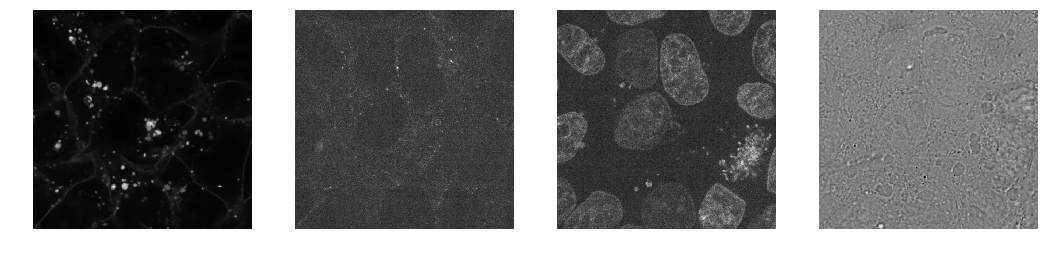

In [3]:
N_CHANNELS = IMG.shape[1]
MID_SLICE = np.int(0.5*IMG.shape[2])

fig, ax = plt.subplots(1, N_CHANNELS, figsize=(18,16), dpi=72, facecolor='w', edgecolor='k')
for channel in range(N_CHANNELS):
    ax[channel].axis('off')
    ax[channel].imshow(IMG[0,channel,MID_SLICE,:,:], cmap=plt.cm.gray)

In [4]:
#####################
## PARAMETER ##
structure_channel = 1
#####################

structure_img = IMG[0,structure_channel,:,:,:]
view(single_fluorescent_view(structure_img))

Viewer(rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x7f6450d1cb…

## Image segmentation

### Step 1: Pre-Processing

About selected algorithms and tuned parameters

* **Intensity normalization**

Parameter for Centrin-2:  `intensity_scaling_param = [8000]`

Parameter for Desmoplakin:  `intensity_scaling_param = [8000]`

Parameter for PMP34:  `intensity_scaling_param = [6000]`

These three all use Min-Max Normalization, just with slightly different absolute intensity upper bound. Using Min-Max normalization is meant to keep the full intensity profile near the brightest area, usually the center of the "balls" as in these structures. Such bright centers are important for the success of these workflows. Meanwhile, adding an absolute intensity upper bound is meant to be robust to imaging artifacts, like dead pixels. If there is one dead pixel in an image stack with extremely high intensity (way out of normal intensity range), the Min-Max normalization will squeeze the value of actual structures into a tiny range close to 0. So, we add an upper bound. For example, in Centrin-2, if a pixel has intensity value over 8000, this pixel will be treated as an outlier and reset as the minimum intensity of the stack. For your own data, if you don't need such upper bound, you can simply use `intensity_scaling_param = [0]`, which is a plain Min-Max normalization without any upper bound.

* **Smoothing** 

These three all use 2D gaussian smoothing with `gaussian_smoothing_sigma = 1`. Usually, 3D gaussian is used by default. But, here we apply 2D gaussian slice by slice, because when we do live imaging, these "ball"-shape structures could move visible amount (considering these "balls" themselves are tiny) during the time interval between two consecutive z slices. So, 3D guassian smoothing may further aggravate the subtle shift in consecutive z-slices. If your data do not have such problem, you can certainly try 3D gaussian by `image_smoothing_gaussian_3d(struct_img, sigma=gaussian_smoothing_sigma)` with `gaussian_smoothing_sigma = 1`. To deal with very noisy data, you may consider increase `gaussian_smoothing_sigma` from 1 to a higher value, like 1.5 or 2.

In [4]:
################################

intensity_scaling_param = [8000]
gaussian_smoothing_sigma = 1
################################



# intensity normalization
structure_img = intensity_normalization(structure_img, scaling_param=intensity_scaling_param)

# smoothing with gaussian filter
structure_img_smooth = image_smoothing_gaussian_slice_by_slice(structure_img, sigma=gaussian_smoothing_sigma)

intensity normalization: using min-max normalization with absolute intensity upper bound 8000
intensity normalization completes


In [6]:
# quickly visualize the image after smoothing
view(single_fluorescent_view(structure_img_smooth))

Viewer(rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x7f4a8833cd…

### Step 2: Core Algorithm

#### step 2.1: Apply 3D Spot filter (S3)

Parameter syntax: `[[scale_1, cutoff_1], [scale_2, cutoff_2], ....]` 
* `scale_x` is set based on the estimated radius of your target dots. For example, if visually the diameter of the dots is usually 3~4 pixels, then you may want to set `scale_x` as `1` or something near `1` (like `1.25`). Multiple scales can be used, if you have dots of very different sizes.  
* `cutoff_x` is a threshold applied on the actual filter reponse to get the binary result. Smaller `cutoff_x` may yielf more dots and fatter segmentation, while larger `cutoff_x` could be less permisive and yield less dots and slimmer segmentation. 

Parameter for Centrin-2:  `s3_param = [[1, 0.04]]`

Parameter for Desmoplakin:  `s3_param = [[1, 0.012]]`

Parameter for PMP34:  `s3_param = [[1,0.03]]`


In [5]:
################################
## PARAMETERS for this step ##
s3_param = [[1, 0.04]]
################################

bw = dot_3d_wrapper(structure_img_smooth, s3_param)there any spot should be detected but not? Try to re

In [13]:
# view the segmentation result
viewer_s3 = view(segmentation_quick_view(bw))
viewer_s3

Viewer(rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkImageUC3 *' at 0x7f342712…

##### After quickly visualizing the segmentation results, you can also visualize the segmentation and original image side by side

##### You can select an ROI in above visualization ('viewer_s3'); otherwise, the default ROI is the full image


[See this video for How to select ROI](https://www.youtube.com/watch?v=ZO8ey6-tF_0&index=3&list=PL2lHcsoU0YJsh6f8j2vbhg2eEpUnKEWcl)

In [14]:
view(seg_fluo_side_by_side(structure_img,bw,roi=['ROI',viewer_s3.roi_slice()]))

Viewer(rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x7f34271223…

##### Is the segmentation satisfactory? Here are some possible criteria:
* Note: next step (2.2) can further cut falsely merged spots.
* Is there any spot should be detected but not? Try to reduce `cutoff_x`
* Is there any spot should not be detected but actually appear in the result? Try to increase `cutoff_x` or try a larger `scale_x`
* Is the segmented size of the spots fatter than it should be? Try to increase `cutoff_x` or try a smaller `scale_x`
* Is there any spot that should be solid but segmented as a ring? Try to increase `scale_x`
* Are you observing spots with very different sizes? Try multiple sets of `scale_x` and `cutoff_x` 


#### If the results are satisfactory, go to Step 2.2 directly; otherwise, try to tweak the parameters based on the above suggestions. 

Assumption: the segmentation result is saved in a variable named `bw`.

#### Step 2.2: Watershed for cutting falsely merged spots

This step may take 2~3 minutes or longer, depending on the number of dots in your images. 

In general, no parameter tuning is needed in this step. The only parameter is `minArea=4`, which is the parameter for size thresholding in post-processing. In practice, when we know an object whose size is smaller than `minArea` will be removed eventually, we can just remove them before doing watershed to cut falsely merged cells. This is only meant to avoid unnecessary computation. 

In [16]:
# watershed
minArea = 4
Mask = remove_small_objects(bw>0, min_size=minArea, connectivity=1, in_place=False) 
Seed = dilation(peak_local_max(structure_img,labels=label(Mask), min_distance=2, indices=False), selem=ball(1))
Watershed_Map = -1*distance_transform_edt(bw)
seg = watershed(Watershed_Map, label(Seed), mask=Mask, watershed_line=True)

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


#### Step 3: Post-Processing 

In [17]:
################################
## PARAMETERS for this step ##
minArea = 4 
################################

final_seg = remove_small_objects(seg>0, min_size=minArea, connectivity=1, in_place=False)

## Result inspection

In [18]:
viewer_final = view(segmentation_quick_view(final_seg))
viewer_final

Viewer(rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkImageUC3 *' at 0x7f342712…

### You can also focus your inspection on a small ROI

#### You can select an ROI in above visualization ('viewer_final'); otherwise, the default ROI is the full image


[See this video for How to select ROI](https://www.youtube.com/watch?v=ZO8ey6-tF_0&index=3&list=PL2lHcsoU0YJsh6f8j2vbhg2eEpUnKEWcl)

In [20]:
view(seg_fluo_side_by_side(structure_img, final_seg, roi=['ROI',viewer_final.roi_slice()]))

Viewer(rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x7f34271221…

### You can also inspect the same ROI on the effect of final cutting step (the same ROI as above)

In [22]:
view(seg_fluo_side_by_side(bw, final_seg, roi=['ROI',viewer_final.roi_slice()]))
# left is the final version
# right is the version before cutting

Viewer(rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x7f34271223…

### You may also physically save the segmentation results into a .tiff image

In [24]:
final_seg = final_seg >0
out=final_seg.astype(np.uint8)
out[out>0]=255
writer = omeTifWriter.OmeTifWriter('/allen/aics/assay-dev/Segmentation/documentation/toolkit_paper/test_segmentation.tiff')
writer.save(out)